In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# SHAP
import shap

# Settings
import warnings
warnings.filterwarnings('ignore')


c:\Users\Bob\Desktop\10Acadamy\week-3\AlphaCare-insurance\alphacare\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../data/cleaned_insurance_data.csv')  # Replace with your actual file path
df.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,mmcode_was_missing,make_was_missing,Model_was_missing,bodytype_was_missing,NumberOfDoors_was_missing,VehicleIntroDate_was_missing,Cylinders_was_missing,cubiccapacity_was_missing,kilowatts_was_missing,LossRatio
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0,0,0,0,0,0,0,0,0,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0,0,0,0,0,0,0,0,0,0.0
2,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0,0,0,0,0,0,0,0,0,0.0
3,145247,12827,2015-01-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0,0,0,0,0,0,0,0,0,0.0
4,145247,12827,2015-04-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0,0,0,0,0,0,0,0,0,0.0


In [4]:
df.info()
df.isnull().sum()

# Fill or drop based on your strategy
df.dropna(inplace=True)  # Simple approach for demo


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618176 entries, 0 to 618175
Data columns (total 63 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   UnderwrittenCoverID           618176 non-null  int64  
 1   PolicyID                      618176 non-null  int64  
 2   TransactionMonth              618176 non-null  object 
 3   IsVATRegistered               618176 non-null  bool   
 4   Citizenship                   618176 non-null  object 
 5   LegalType                     618176 non-null  object 
 6   Title                         618176 non-null  object 
 7   Language                      618176 non-null  object 
 8   Bank                          535640 non-null  object 
 9   AccountType                   587442 non-null  object 
 10  MaritalStatus                 613105 non-null  object 
 11  Gender                        613555 non-null  object 
 12  Country                       618176 non-nul

In [5]:
# Example: Create a new feature - Claim Ratio
df['ClaimRatio'] = df['TotalClaims'] / (df['CalculatedPremiumPerTerm'] + 1)

# You can add more like 'VehicleAge', 'CustomerTenure', etc.


In [6]:
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [7]:
# Only keep rows with claims > 0
severity_data = df[df['TotalClaims'] > 0]

X = severity_data.drop(['TotalClaims'], axis=1)
y = severity_data['TotalClaims']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
import sklearn
print(sklearn.__version__)


1.7.0


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")



Linear Regression RMSE: 25656.04, R²: 0.55


In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")


Random Forest RMSE: 4337.43, R²: 0.99


In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}")


XGBoost RMSE: 9582.90, R²: 0.94


In [16]:
model_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_xgb]
})
model_results


,Model,RMSE,R²
0,Linear Regression,25656.043554,0.553565
1,Random Forest,4337.434212,0.987240
2,XGBoost,9582.896625,0.937717


In [17]:
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

X_cls = df.drop(['TotalClaims', 'HasClaim'], axis=1)
y_cls = df['HasClaim']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = XGBClassifier(random_state=42)
clf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf.predict(X_test_cls)

print(classification_report(y_test_cls, y_pred_cls))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94828
           1       1.00      1.00      1.00       445

    accuracy                           1.00     95273
   macro avg       1.00      1.00      1.00     95273
weighted avg       1.00      1.00      1.00     95273



In [18]:
# Combine outputs from regression and classification
prob_claim = clf.predict_proba(X_test_cls)[:, 1]
predicted_severity = xgb.predict(X_test_cls)

premium = (prob_claim * predicted_severity) + 500  # Add fixed expense & margin

# Show first few
pd.DataFrame({'Probability': prob_claim, 'Severity': predicted_severity, 'Premium': premium}).head()


,Probability,Severity,Premium
0,1.067520e-06,421.171814,500.000458
1,1.230660e-06,878.436768,500.001068
2,2.467854e-07,393.122101,500.000092
3,1.586924e-05,1451.595337,500.023041
4,7.297906e-07,-661.333313,499.999512


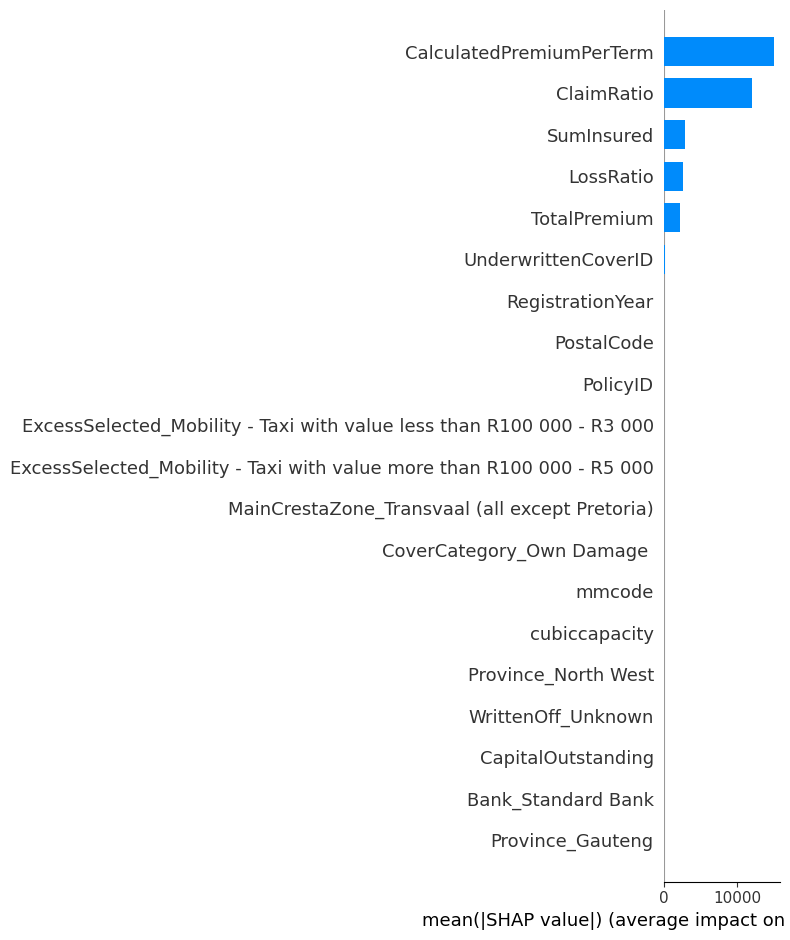

In [19]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


In [20]:
# Save important results
model_results.to_csv("../data/model_comparison.csv", index=False)
